# Kurtosis


Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import dateutil
import requests
import math


%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 5]

### Collect data

Pull in the relevant data from Bitmex

In [2]:
def collect_data(from_time: str, to_time: str, tf: str, contract: str = "ETHUSD") -> pd.DataFrame:

    url = "https://www.bitmex.com/api/v1/trade/bucketed"
    candles = {'timestamp': [], 'open': [], 'high': [], 'low': [], 'close': []}

    # Set inputs
    data = dict()
    data['symbol'] = contract
    data['partial'] = True  # returns a candle if it is not finished yet
    data['binSize'] = tf
    data['count'] = 500   # how many candles we can return (500 max)
    data['reverse'] = True

    data["startTime"] = datetime.datetime.strptime(from_time, '%Y-%m-%d %H:%M')
    data["endTime"] = datetime.datetime.strptime(to_time, '%Y-%m-%d %H:%M')

    BITMEX_TF_MINUTES = {"1m": 1, "5m": 5, "10m": 10, "15m": 15, "1h": 60, "1d": 1440}


    try:
        response = requests.get(url, params=data)
    except Exception as e:
        print(f"Connecton error while making GET request to {url}: {e}")
        return

    if response.status_code == 200:
        raw_candles = response.json()
    else:
        print(f"Error while making GET request to {url}: {response.status_code}")
        print(response.headers)
        return None
    
    if raw_candles is not None:
        for idx, c in enumerate(reversed(raw_candles)):
            ts = dateutil.parser.isoparse(c['timestamp'])
            ts = ts - datetime.timedelta(minutes=BITMEX_TF_MINUTES[tf])
            candles['timestamp'].append(ts)
            candles["open"].append(c["open"])
            candles["high"].append(c["high"])
            candles["low"].append(c["low"])
            candles["close"].append(c["close"])


    return pd.DataFrame(candles)

Kurtosis function

In [5]:
def get_estimator(price_data, window=30, clean=True):

    log_return = (price_data['close'] / price_data['close'].shift(1)).apply(np.log)

    result = log_return.rolling(
        window=window,
        center=False
    ).kurt()

    if clean:
        return result.dropna()
    else:
        return result

Build the `DataFrame`

In [8]:
# from_time = "2022-07-30 00:00"
# to_time = "2022-08-01 15:00"
from_time = "2022-08-01 00:00"
to_time = "2022-08-01 16:00"
tf = "5m"
contract = "XBTUSD"

data = collect_data(from_time, to_time, tf, contract)
kurt = get_estimator(data)
data['kurtosis'] = kurt
data = data.iloc[30:]
data

,timestamp,open,high,low,close,kurtosis
30,2022-08-01 02:25:00+00:00,23410.0,23433.0,23410.0,23419.5,-0.602188
31,2022-08-01 02:30:00+00:00,23419.5,23432.0,23416.5,23430.0,-0.741569
32,2022-08-01 02:35:00+00:00,23430.0,23430.0,23405.0,23406.5,-0.926217
33,2022-08-01 02:40:00+00:00,23406.5,23406.5,23393.0,23393.5,-1.030150
34,2022-08-01 02:45:00+00:00,23393.5,23404.5,23381.5,23381.5,-1.105497
...,...,...,...,...,...,...
188,2022-08-01 15:35:00+00:00,23325.0,23329.0,23275.5,23300.0,0.301816
189,2022-08-01 15:40:00+00:00,23300.0,23300.0,23284.5,23292.0,0.444542
190,2022-08-01 15:45:00+00:00,23292.0,23341.5,23289.5,23341.5,0.350714
191,2022-08-01 15:50:00+00:00,23341.5,23341.5,23302.0,23313.0,0.286610


### Volatility Plot

<AxesSubplot:>

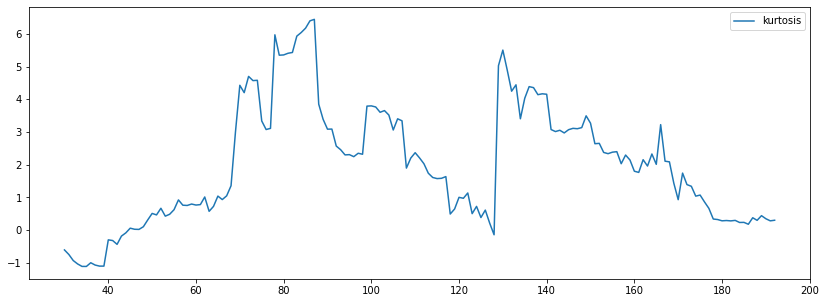

In [9]:
data.plot(y='kurtosis')

### Close Price Plot

<AxesSubplot:>

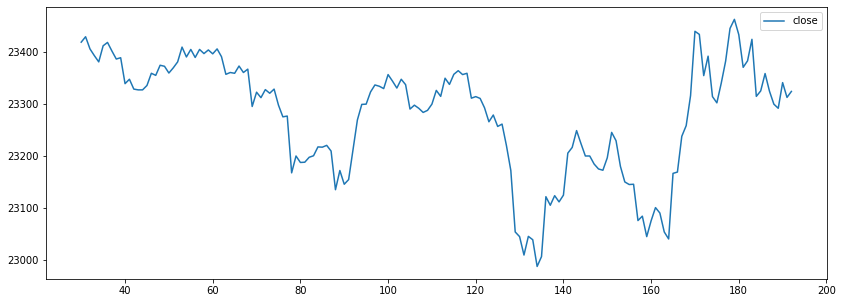

In [10]:
data.plot(y='close')